<a href="https://colab.research.google.com/github/manuvillalba-uclm/Natural_Lenguaje_Processing-ELM/blob/Preprocessing/Machine_Learning_NLP_Vectorization_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# dataframes library
!pip install pyspellchecker 
!pip install contractions
!pip install nltk --upgrade
!pip install emoji
import nltk
nltk.download("popular")
nltk.download('vader_lexicon') #sentiment analysis
nltk.download('twython') #twitter not necessary

Requirement already up-to-date: nltk in /usr/local/lib/python3.6/dist-packages (3.5)


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

False

In [20]:
import pandas as pd
import re


from nltk.tokenize.casual import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

#Correcciones y emoji
import emoji
from textblob import TextBlob
from spellchecker import SpellChecker
import contractions
from multiprocessing import Pool

#Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

#Feature selection 
from sklearn.feature_selection import SelectKBest, chi2

#Classification
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [3]:
raw_dataset_tweets = pd.read_csv('https://raw.githubusercontent.com/manuvillalba-uclm/Natural_Lenguaje_Processing-ELM/main/labeled_data.csv?token=ANLXPWL27WHT4VS5U4LHMVK72D27M', index_col=[0])
ds_alt_twitter = pd.read_csv('https://raw.githubusercontent.com/manuvillalba-uclm/Natural_Lenguaje_Processing-ELM/Preprocessing/preprocesado.csv?token=ANLXPWIF2CJXX2UOC77N4SK73CVEE', index_col=[0])
ds_alt_twitter = ds_alt_twitter.iloc[:20000,0]
ds_alt_twitter


0        ['woman', 'complain', 'clean', 'hous', 'man', ...
1        ['boy', 'day', 'cold', 'tea', 'down', 'bad', '...
2        ['dawn', 'ever', 'fuck', 'bitch', 'sta', 'cri'...
3                              ['look', 'like', 'tyranni']
4        ['shit', 'hear', 'might', 'true', 'might', 'ba...
                               ...                        
19995    ['far', 'been', 'mon', '2', 'sex', 'tape', 'po...
19996    ['day', '2', 'fix', 's', 'simpson', 'marathon'...
19997    ['almost', 'ran', 'fine', 'red', 'bitch', 'ove...
19998                             ['trash', 'though', '?']
19999    ['critic', 'mania', 'say', 'n', 'word', 'sure'...
Name: tweet, Length: 20000, dtype: object

# Vectorization


In [4]:
def identity_tokenizer(text):
    return text

In [5]:
%%time
# TF-IDF
vectorizer = TfidfVectorizer( lowercase=False)    
vectors = vectorizer.fit_transform(ds_alt_twitter)

feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
tweets_vectorization = pd.DataFrame(denselist, columns=feature_names)


CPU times: user 1min 51s, sys: 7.41 s, total: 1min 58s
Wall time: 1min 59s


In [6]:
tweets_vectorization

,00,000,0000000000,003,007,01,02,0221,0300,05,06,07,08,09,10,100,1000,100000,1000x,100gram,100k,100x,105,106,1069thearrow,107,108,10min,10thingsthatgetsonmynerv,10x,10yr,11,1114,113,114,116,11wd,12,120,1200,...,younnnnng,youoksi,youpeopl,your,yourenotmytyp,youresilli,yourewelcom,yourself,yourwifecantread,youth,youuuuu,youuuuuu,youuuuuuuu,youwillnotbetakenseriouslyif,yuhhh,yuhhhh,yuma,yungin,yyyyyeelllloooowwwwww,yáll,zaaaammnn,ze,zeal,zeitgeist,zenger,zere,zero,zest,zigeun,zimmerman,zip,zipperhead,zon,zone,zookeep,zrgrizz,zulema,zzz,zzzzzz,últimahora
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Feature Selection

In [14]:
class_label = raw_dataset_tweets.copy()
class_label = class_label['class']


In [15]:
%%time

n_tweets = tweets_vectorization.shape[0]
n_features = tweets_vectorization.shape[1]
n_features = int(n_features*0.3)

class_label = class_label.iloc[0:n_tweets]
class_label.reset_index(inplace = True, drop = True)
#quitamos el 70% de las features, se supone que en función del target class_label
tweets_vectorization_selected = SelectKBest(chi2, k=n_features).fit_transform(tweets_vectorization,class_label)
tweets_vectorization_selected

df_tweets_vectorization_selected = pd.DataFrame(data=tweets_vectorization_selected)
df_tweets_vectorization_selected['target']= class_label

CPU times: user 1.87 s, sys: 89.7 ms, total: 1.96 s
Wall time: 1.52 s


# Classification

In [16]:
tweets_classification = df_tweets_vectorization_selected.copy()

In [17]:
model = MultinomialNB()

In [18]:
train, test = train_test_split(tweets_classification, test_size=0.30)
train.reset_index(inplace = True)
test.reset_index(inplace = True)
print(train.shape)
print(test.shape)

(14000, 2948)
(6000, 2948)


In [12]:
model.fit(train.loc[:, train.columns != 'target'], train['target'])
labels = model.predict(test.loc[:, test.columns != 'target'])

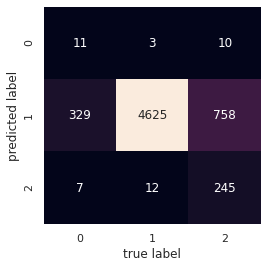

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
mat = confusion_matrix(test['target'], labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [21]:
acc = accuracy_score(test['target'], labels)
print ('Acc', acc)

Acc 0.7386666666666667
